# CI width by changing sample size for QMC and IID Beta for the Hedged (Betting) CI Method

[This JRSSB article by Ian Waudby-Smith and Aaditya Ramdas](https://academic.oup.com/jrsssb/article/86/1/1/7043257) takes $X_1, X_2, \ldots \stackrel{\text{IID}}{\sim} F$ and computes a sequential confidence interval for $\mu = \mathbb{E}(X)$.

For Quasi-Monte Carlo (QMC), also know as low discrepancy sequences, we are going to take 

$$
X_i = \frac{1}{m} \sum_{j=1}^m T_{ij},
$$ 

where for each $i$, $\{T_{ij}\}_{j=1}^m$ is a QMC set that mimics $F$. Therefore, $X_i$ is close to $\mu$, and the sequence $\{X_i\}_{i=1}^n$ is an IID sequence based on $N = mn$ samples.

In this notebook, $F$ is a Beta Distribution and DigitalNetB2 (Sobol) has been used for QMC. We refer to $m$ as gen_samples and $n$ as spawn_samples.

Importing the necessary modules:

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import beta
from confseq.betting import betting_ci_seq
import qmcpy as qp

The parameters used for our numerical experiments

In [56]:
alpha = 0.05 # Significanc level, confidence level = 1 - alpha
num_times = 10  #number of different times where CI will be computed
space_times = 10  #space between different times where CI will be computed
spawn_samples = num_times*space_times # The number of IID replications for low discrepancy or QMC samples (n)
gen_samples = 2**5 # The number of low discrepancy or QMC samples generated per replication (m)
N = spawn_samples * gen_samples # The maxmimum sample size (N = mn)
beta_param = np.array([10,30]) #parameters for the beta distribution

The plot function used for both the IID_Beta and IID_QMC_Beta experiments:

In [1]:
def plot_func(times,lower_bound,upper_bound, title):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(times,lower_bound, color = "red")
    axs[0].plot(times,upper_bound, color = "red")
    axs[0].axhline(y=0.25, color="blue", linestyle="--")
    axs[1].plot(times,upper_bound - lower_bound, color = "red")
    axs[0].set_xlabel("sample size N") 
    axs[0].set_ylabel("Confidence Interval")
    axs[1].set_xlabel("sample size N") 
    axs[1].set_ylabel("CI Width")
    fig.text(0.45,1,title)
    fig.tight_layout()

IID_Beta Numerical Experiments

In [58]:
times_iid = (num_times * np.arange(1,space_times+1)) * gen_samples # The times (sample sizes) for which we'll use compute the lower and upper bounds on the confidence intervals
x_iid = np.random.beta(beta_param[0], beta_param[1], N) # The IID_Beta samples
lower_bound_iid,upper_bound_iid = betting_ci_seq(x_iid, times=times_iid, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential CI according to the code from the paper above


Using 11 cores


/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57


IID_QMC_Beta Numerical Experiments

In [59]:
# The function to generate the IID_QMC_Beta samples
def gen_qmc_samples_iid(distribution = qp.SciPyWrapper(discrete_distrib=qp.DigitalNetB2(1,seed = 7),scipy_distribs=beta(a=beta_param[0], b = beta_param[1]))
                         , spawn_samples = 11 ,gen_samples = 2**8):
    spw = distribution
    spws = spw.spawn(spawn_samples)
    samples = spws[0].gen_samples(gen_samples).flatten()
    for i in range (len(spws)- 1):
        curr_samples = spws[i + 1].gen_samples(gen_samples).flatten()
        samples = np.vstack((samples,curr_samples))
    return np.mean(samples, axis = 1)

times_qmc = num_times * np.arange(1,space_times+1) # The times (sample sizes) for which we'll compute the lower and upper bound values
x_qmc = gen_qmc_samples_iid(spawn_samples=spawn_samples,gen_samples=gen_samples) # The IID_QMC_Beta samples
lower_bound_qmc,upper_bound_qmc = betting_ci_seq(x_qmc, times=times_qmc, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential CI according to the code from the paper above

Using 11 cores


Histograms and kernel density estimates of IID_Beta, QMC Uniform, QMC_Beta and IID_QMC_Beta

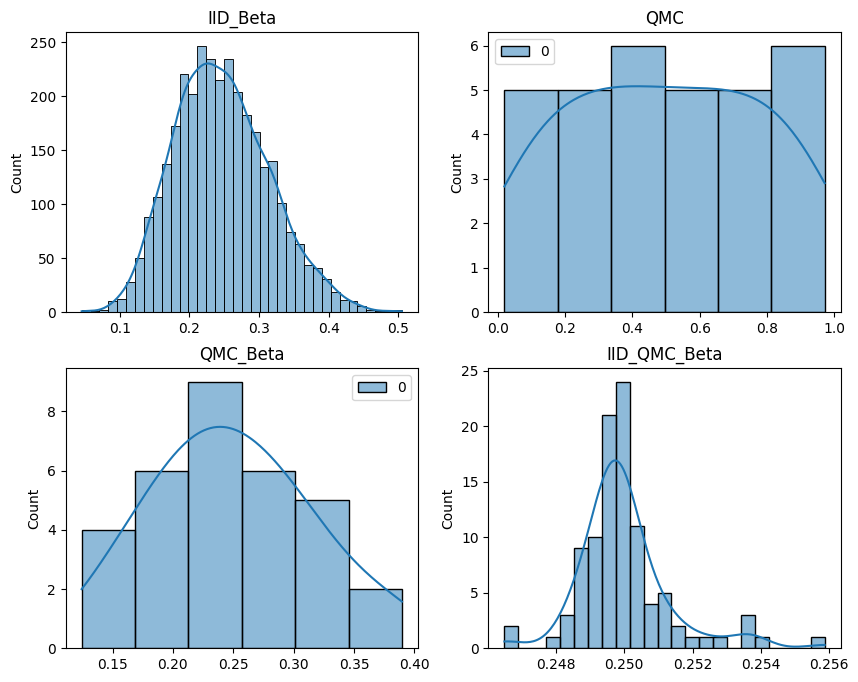

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(x_iid, kde= True, ax=axs[0, 0], edgecolor='black') # IID_Beta Hist and KDE
axs[0, 0].set_title('IID_Beta'); %include N = ?? in the title

#I do not think that this plot is needed
#sns.histplot(qp.DigitalNetB2(1, seed = 7).gen_samples(gen_samples), kde= True, ax=axs[0, 1], edgecolor='black') # QMC Hist and KDE
#axs[0, 1].set_title('QMC Uniform');
#Instead, plot all of the N QMC beta samples

sns.histplot(qp.SciPyWrapper(discrete_distrib=qp.DigitalNetB2(1,seed = 7),scipy_distribs=beta(a=10,b=30)).gen_samples(gen_samples), kde= True, ax=axs[1, 0], edgecolor='black')
    # QMC_Beta Hist and KDE
axs[1, 0].set_title('QMC Transformed to Beta');

sns.histplot(x_qmc, kde= True, ax=axs[1, 1], edgecolor='black') # IID_QMC_Beta Hist and KDE
axs[1, 1].set_title('IID_QMC_Beta');

We note the following:
* The QMC points make a smoother historgram than the IID points.
* The $X_i$ from the QMC points seem to have a heavy-tailed distribution.

## Simulation Plots

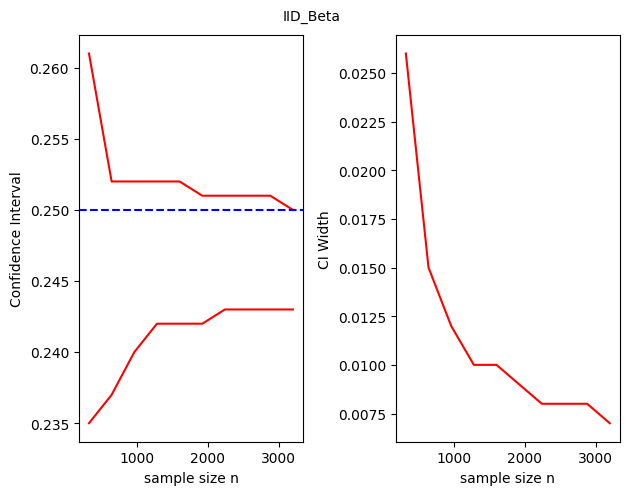

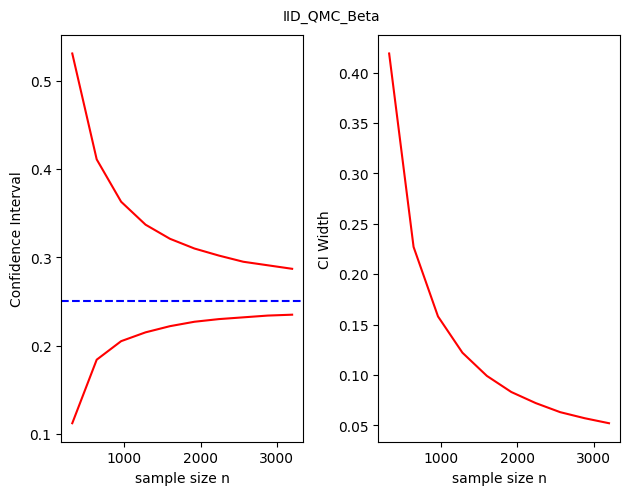

In [61]:
plot_func(times_iid,lower_bound_iid,upper_bound_iid,"IID_Beta") # IID_Beta Plot
plot_func(times_qmc * gen_samples,lower_bound_qmc,upper_bound_qmc,"IID_QMC_Beta") # IID_QMC_Beta Plot

## Printing the Simulation Output

In [62]:
# Printing out the mean, std, and last upper bound,lower bound, and CI width (upper bound,lower bound, and CI width at sample size N)
print("IID_Beta mean for sample size N =", N, "is", x_iid.mean())
print("IID_Beta std for sample size N =", N, "is", x_iid.std())
print("IID_Beta Upper bound at sample size N =", N, "is", upper_bound_iid[len(upper_bound_iid) - 1])
print("IID_Beta Lower bound at sample size N =",N, "is", lower_bound_iid[len(lower_bound_iid) - 1])
print("IID_Beta CI width at sample size N =",N, "is", upper_bound_iid[len(upper_bound_iid) - 1] - lower_bound_iid[len(lower_bound_iid) - 1])
print("The IID_Beta CLT CI width for sample size N =", N,"would be", norm.ppf(1 - alpha / 2) * x_iid.std() / np.sqrt(N))

print("")

# Printing out the mean, std, and last upper bound,lower bound, and CI width (upper bound,lower bound, and CI width at sample size spawn_samples)
print("IID_QMC_Beta mean for sample size spawn_samples =", spawn_samples, "is", x_qmc.mean())
print("IID_QMC_Beta std for sample size spawn_samples =", spawn_samples, "is", x_qmc.std())
print("IID_QMC_Beta Upper bound based on a total of N =", N, "is", upper_bound_qmc[len(upper_bound_qmc) - 1])
print("IID_QMC_Beta Lower bound at sample size spawn_samples =", spawn_samples, "is", lower_bound_qmc[len(lower_bound_qmc) - 1])
print("IID_QMC_Beta CI width at sample size spawn_samples =", spawn_samples, "is", upper_bound_qmc[len(upper_bound_qmc) - 1] - lower_bound_iid[len(lower_bound_qmc) - 1])
print("The IID_QMC_Beta CLT CI width for sample size spawn_samples =", spawn_samples,"would be", norm.ppf(1 - alpha / 2) * x_qmc.std() / np.sqrt(spawn_samples))

IID_Beta mean for sample size N = 3200 is 0.24661659236500483
IID_Beta std for sample size N = 3200 is 0.06799320194365185
IID_Beta Upper bound at sample size N = 3200 is 0.25
IID_Beta Lower bound at sample size N = 3200 is 0.243
IID_Beta CI width at sample size N = 3200 is 0.007000000000000006
The IID_Beta CLT CI width for sample size N = 3200 would be 0.0023558009650871763

IID_QMC_Beta mean for sample size spawn_samples = 100 is 0.24999892301082444
IID_QMC_Beta std for sample size spawn_samples = 100 is 0.0013547078658965011
IID_QMC_Beta Upper bound at sample size spawn_samples = 100 is 0.28700000000000003
IID_QMC_Beta Lower bound at sample size spawn_samples = 100 is 0.23500000000000001
IID_QMC_Beta CI width at sample size spawn_samples = 100 is 0.04400000000000004
The IID_QMC_Beta CLT CI width for sample size spawn_samples = 100 would be 0.00026551786267302595


Some further observations and questions:
* In both the IID and QMC cases, the CI computed by the paper is wider than that computed by a CLT.  Is this to be expected?
* In the case of QMC, the CI computed by the paper is orders of magnitude larger than the CLT and larger than the IID.  Why is this?